In [48]:
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [319]:
# Input File
df = pd.read_pickle('df.pkl').astype(float)

# Machine Learning Stationary M30Y (Weekly Returns)

In [320]:
# Dropping features with high multicollinearity
model_df = pd.concat([df[df.columns[:6]].diff().dropna(),df['A-T10'].iloc[1:]], axis = 1)

# SARIMAX Modeling

In [327]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn import metrics



X = model_df.iloc[:-1]
y = model_df['M30Y'].shift(-1).dropna()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0, shuffle = False)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Obtaining optimal p,d,q

In [322]:
p_values = range(0, 2)
d_values = range(0, 2)
q_values = range(0, 2)
seasonal_periods = [52*2]

param_grid = list(itertools.product(p_values, d_values, q_values, seasonal_periods))

best_aic = float('inf')
best_params = None

for params in param_grid:
    model = sm.tsa.statespace.SARIMAX(y_train, exog=X_train, order=(params[0], params[1], params[2]),
                                       seasonal_order=(0, 0, 0, params[3]))
    results = model.fit(maxiter=100,method='bfgs')
    aic = results.aic

    if aic < best_aic:
        best_aic = aic
        best_params = params

print(f'Best AIC: {best_aic}')
print(f'Best Parameters (P, D, Q, m): {best_params}')

Optimization terminated successfully.
         Current function value: -0.840264
         Iterations: 4
         Function evaluations: 17
         Gradient evaluations: 17
Optimization terminated successfully.
         Current function value: -0.879222
         Iterations: 23
         Function evaluations: 30
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: -0.704800
         Iterations: 4
         Function evaluations: 17
         Gradient evaluations: 17
Optimization terminated successfully.
         Current function value: -0.837918
         Iterations: 32
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: -0.869165
         Iterations: 18
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: -0.881221
         Iterations: 23
         Function evaluations: 3

Optimization terminated successfully.
         Current function value: -0.881221
         Iterations: 23
         Function evaluations: 30
         Gradient evaluations: 30
MSE: 0.009613526896204214
RMSE: 0.09804859456516557
RRMSE: 15.042237799749
MAE: 0.06676843397234748
RMAE: 10.243356019360139
EV: -0.09158409976037074
R2: -0.09169001684784361


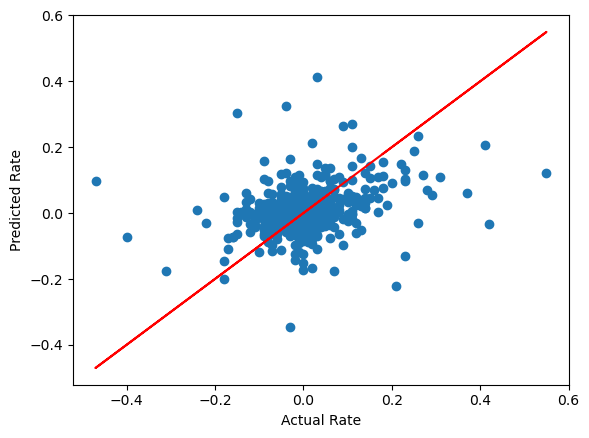

In [323]:
model = sm.tsa.statespace.SARIMAX(y_train, exog=X_train, order=(best_params[0], best_params[1], best_params[2]),
                                  seasonal_order=(0, 0, 0, best_params[3]))
results = model.fit(method='bfgs',maxiter=100)

plm = results.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1,
                     exog=X_test)

plt.scatter(y_test,plm)
plt.plot(y_test,y_test,"r")
plt.xlabel('Actual Rate')
plt.ylabel('Predicted Rate')

print("MSE:",metrics.mean_squared_error (y_test,plm))
print("RMSE:", np.sqrt(metrics.mean_squared_error (y_test,plm)))
print("RRMSE:",np.sqrt(metrics.mean_squared_error (y_test,plm))/y_test.mean())
print("MAE:", metrics.mean_absolute_error (y_test, plm))
print("RMAE:", metrics.mean_absolute_error (y_test, plm)/y_test.mean())
print("EV:", metrics.explained_variance_score(y_test,plm))
print("R2:", metrics.r2_score(y_test,plm))

In [324]:
# Overtraining check
train_predictions = results.get_prediction(start=0, end=len(y_train) - 1, exog=X_train)
train_mse = metrics.mean_squared_error(y_train, train_predictions.predicted_mean)

test_predictions = results.get_forecast(steps=len(y_test), exog=X_test)
test_mse = metrics.mean_squared_error(y_test, test_predictions.predicted_mean)

print(f'Training MSE: {train_mse}')
print(f'Test MSE: {test_mse}')

Training MSE: 0.010046720524336585
Test MSE: 0.009613526896204214


# Random Forest Regressor Modeling

In [325]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

def get_learning_curve_data(estimator, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)

    return {
        "Train Sizes": train_sizes,
        "Train Scores": train_scores.mean(axis=1),
        "Test Scores": test_scores.mean(axis=1)
    }
import joblib

MSE: 0.006610678262349353
RMSE: 0.08130607764705756
RRMSE: 12.473665328461623
MAE: 0.0539840420194467
RMAE: 8.282023837766044
EV: 0.25496384653784365
R2: 0.24930657171726323
Cross-Validation RMSE: 0.11198758038566857


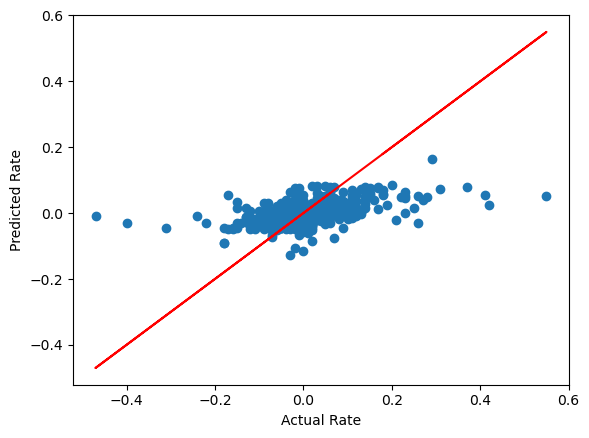

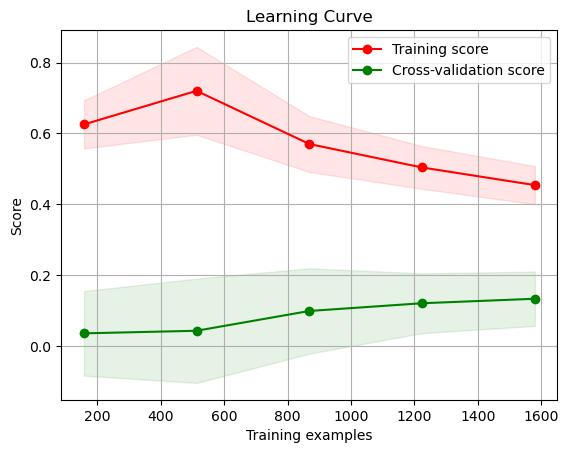

{'Train Sizes': array([ 158,  513,  869, 1224, 1580]), 'Train Scores': array([0.62535124, 0.72016727, 0.56996594, 0.503846  , 0.45402725]), 'Test Scores': array([0.03557314, 0.04282853, 0.09875178, 0.12054007, 0.13318931])}


In [328]:
rf = RandomForestRegressor(n_estimators=500, max_depth=5, random_state = 0)
rf.fit(X_train,y_train)
p2 = rf.predict(X_test)

# PREDICTIONS
plt.scatter(y_test,p2)
plt.plot(y_test,y_test,"r")
plt.xlabel('Actual Rate')
plt.ylabel('Predicted Rate')

print("MSE:",metrics.mean_squared_error (y_test,p2))
print("RMSE:", np.sqrt(metrics.mean_squared_error (y_test,p2)))
print("RRMSE:",np.sqrt(metrics.mean_squared_error (y_test,p2))/y_test.mean())
print("MAE:", metrics.mean_absolute_error (y_test, p2))
print("RMAE:", metrics.mean_absolute_error (y_test, p2)/y_test.mean())
print("EV:", metrics.explained_variance_score(y_test,p2))
print("R2:", metrics.r2_score(y_test,p2))
cv_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print("Cross-Validation RMSE:", np.sqrt(-cv_scores.mean()))
plot_learning_curve(rf, "Learning Curve", X_train, y_train, cv=5, n_jobs=-1)
plt.show()
#print(get_learning_curve_data(rf, X_train, y_train, cv=5, n_jobs=-1))

# Non-Stationary Data Modeling (M30Y)

Train, Test, Split

In [329]:
model_df = df.copy()

In [330]:
X = model_df.iloc[:-1]
y = model_df['M30Y'].shift(-1).dropna()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0, shuffle = False)

# Random Forest Modeling

n_estimators = 50, max_depth = 5

MSE: 0.2576368273406106
RMSE: 0.5075793803343578
RRMSE: 0.12213670561095225
MAE: 0.42292256784379784
RMAE: 0.10176609051955506
EV: 0.8451161805640471
R2: 0.7772545789171057
Cross-Validation RMSE: 0.8181889993626674


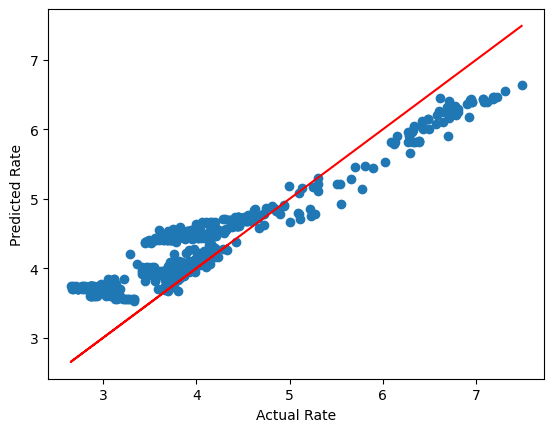

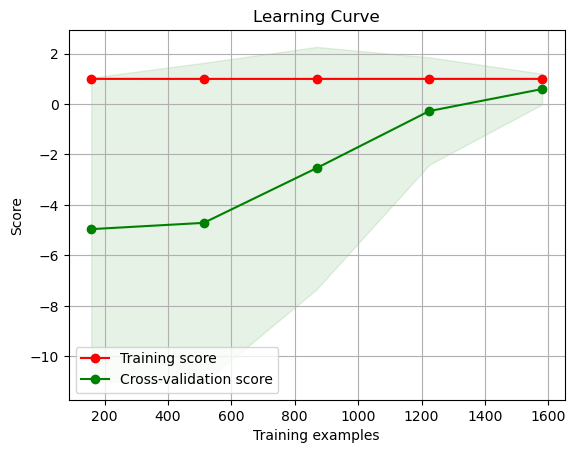

{'Train Sizes': array([ 158,  513,  869, 1224, 1580]), 'Train Scores': array([0.99840206, 0.99726854, 0.99715008, 0.99761003, 0.99789785]), 'Test Scores': array([-4.95949762, -4.71049238, -2.53883546, -0.27881871,  0.59449467])}


In [332]:
rf = RandomForestRegressor(n_estimators=50, max_depth=5,max_features='sqrt', random_state = 0)
rf.fit(X_train,y_train)
p2 = rf.predict(X_test)
joblib.dump(rf, 'rfm.pkl')

# PREDICTIONS
plt.scatter(y_test,p2)
plt.plot(y_test,y_test,"r")
plt.xlabel('Actual Rate')
plt.ylabel('Predicted Rate')

print("MSE:",metrics.mean_squared_error (y_test,p2))
print("RMSE:", np.sqrt(metrics.mean_squared_error (y_test,p2)))
print("RRMSE:",np.sqrt(metrics.mean_squared_error (y_test,p2))/y_test.mean())
print("MAE:", metrics.mean_absolute_error (y_test, p2))
print("RMAE:", metrics.mean_absolute_error (y_test, p2)/y_test.mean())
print("EV:", metrics.explained_variance_score(y_test,p2))
print("R2:", metrics.r2_score(y_test,p2))
cv_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print("Cross-Validation RMSE:", np.sqrt(-cv_scores.mean()))
plot_learning_curve(rf, "Learning Curve", X_train, y_train, cv=5, n_jobs=-1)
plt.show()
print(get_learning_curve_data(rf, X_train, y_train, cv=5, n_jobs=-1))

# LSTM Deep Learning Model

In [186]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [335]:
model_data = df.copy()

In [225]:
def lstm_prep(df,window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [r for r in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size][0]
        y.append(label)
    return np.array(X), np.array(y)

X,y = lstm_prep(model_data, len(model_data.columns)+1)
print(X.shape, y.shape)

# Train-Test-Validation Split
train_size = int(len(X) * 0.8)
val_size = int(len(X) * 0.1)

X_train, y_train = X[:train_size-val_size], y[:train_size-val_size]
X_val, y_val = X[train_size-val_size:train_size], y[train_size-val_size:train_size]
X_test, y_test = X[train_size:], y[train_size:]

training_mean = np.mean(X_train[:,:,0])
training_std = np.std(X_train[:,:,0])

def preprocess(X):
    X[:,:,0] = (X[:,:,0]- training_mean)/training_std
    
preprocessing_params = {'training_mean': training_mean, 'training_std': training_std}
joblib.dump(preprocessing_params, 'preprocessing_params.pkl')

preprocess(X_train)
preprocess(X_val)
preprocess(X_test)

print(X_train.shape, y_train.shape,X_val.shape, y_val.shape,X_test.shape, y_test.shape)

# LSTM
model0 = Sequential()
model0.add(InputLayer((11,10)))
model0.add(LSTM(32))
model0.add(Dense(16, 'relu'))
model0.add(Dense(1, 'linear'))

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
cp = ModelCheckpoint('model0/', save_best_only = True)
model0.compile(loss = MeanSquaredError(), optimizer = Adam(learning_rate=.001), metrics = [RootMeanSquaredError()])
history = model0.fit(X_train, y_train, validation_data = (X_val,y_val), epochs = 50, callbacks =[cp], verbose=0)

(2460, 11, 10) (2460,)
(1722, 11, 10) (1722,) (246, 11, 10) (246,) (492, 11, 10) (492,)
INFO:tensorflow:Assets written to: model0/assets


INFO:tensorflow:Assets written to: model0/assets


INFO:tensorflow:Assets written to: model0/assets


INFO:tensorflow:Assets written to: model0/assets


INFO:tensorflow:Assets written to: model0/assets


INFO:tensorflow:Assets written to: model0/assets


INFO:tensorflow:Assets written to: model0/assets


INFO:tensorflow:Assets written to: model0/assets


INFO:tensorflow:Assets written to: model0/assets


INFO:tensorflow:Assets written to: model0/assets


INFO:tensorflow:Assets written to: model0/assets


INFO:tensorflow:Assets written to: model0/assets


INFO:tensorflow:Assets written to: model0/assets


INFO:tensorflow:Assets written to: model0/assets


INFO:tensorflow:Assets written to: model0/assets


INFO:tensorflow:Assets written to: model0/assets


INFO:tensorflow:Assets written to: model0/assets


INFO:tensorflow:Assets written to: model0/assets


INFO:tensorflow:Assets written to: model0/assets


INFO:tensorflow:Assets written to: model0/assets


INFO:tensorflow:Assets written to: model0/assets


INFO:tensorflow:Assets written to: model0/assets


INFO:tensorflow:Assets written to: model0/assets


INFO:tensorflow:Assets written to: model0/assets


INFO:tensorflow:Assets written to: model0/assets


INFO:tensorflow:Assets written to: model0/assets


INFO:tensorflow:Assets written to: model0/assets


INFO:tensorflow:Assets written to: model0/assets


INFO:tensorflow:Assets written to: model0/assets


INFO:tensorflow:Assets written to: model0/assets


INFO:tensorflow:Assets written to: model0/assets


INFO:tensorflow:Assets written to: model0/assets


INFO:tensorflow:Assets written to: model0/assets


INFO:tensorflow:Assets written to: model0/assets


INFO:tensorflow:Assets written to: model0/assets


INFO:tensorflow:Assets written to: model0/assets


INFO:tensorflow:Assets written to: model0/assets


INFO:tensorflow:Assets written to: model0/assets


INFO:tensorflow:Assets written to: model0/assets


INFO:tensorflow:Assets written to: model0/assets


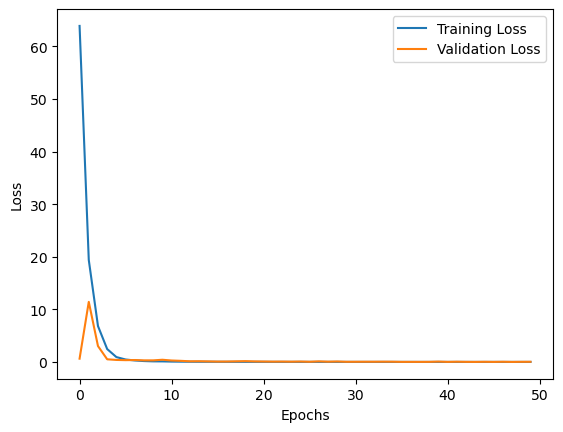

16/16 [==============================] - 0s 6ms/step


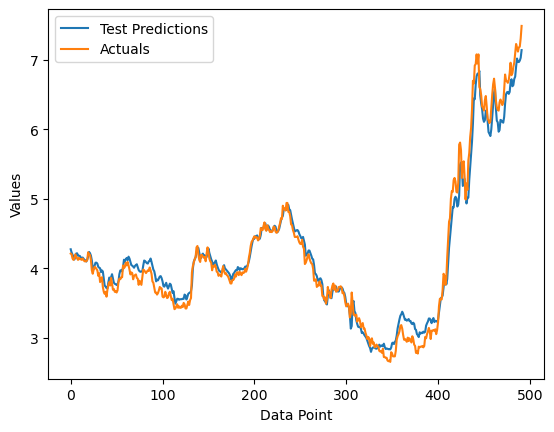

MSE: 0.02622823550496403
RMSE: 0.1619513368421639
RRMSE: 0.02109889852279818
MAE: 0.12432785260968092
RMAE: 0.016197339255838262
EV: 0.9776922962170699
R2: 0.9774137069167322


In [226]:
from tensorflow.keras.models import load_model
model0 = load_model('model0/')
# Plot Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Test Predictions and Actuals
test_predictions = model0.predict(X_test).flatten()

test_results = pd.DataFrame(data={'Test Predictions': test_predictions, 'Actuals': y_test})
plt.plot(test_results['Test Predictions'], label='Test Predictions')
plt.plot(test_results['Actuals'], label='Actuals')
plt.xlabel('Data Point')
plt.ylabel('Values')
plt.legend()
plt.show()

print("MSE:",metrics.mean_squared_error (y_test,test_predictions))
print("RMSE:", np.sqrt(metrics.mean_squared_error (y_test,test_predictions)))
print("RRMSE:",np.sqrt(metrics.mean_squared_error (y_test,test_predictions))/model_data['M30Y'].mean())
print("MAE:", metrics.mean_absolute_error (y_test, test_predictions))
print("RMAE:", metrics.mean_absolute_error (y_test, test_predictions)/model_data['M30Y'].mean())
print("EV:", metrics.explained_variance_score(y_test,test_predictions))
print("R2:", metrics.r2_score(y_test,test_predictions))